## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
import gc
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
from string import punctuation

In [3]:
# vstack - adds rows, hstack - adds columns
# csr_matrix - used to handle sparse matrix
from scipy.sparse import vstack, hstack, csr_matrix

In [4]:
# CountVectorizer - Simply, counts word frequencies 
# TFIDF - More importance/weights on "rare" words. Less importance/weights on "frequent" words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# LabelBinarizer - Converts labels into numerical representation "G,B,R" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer

In [6]:
# Ridge - Reduces multicollinearity in regression. Applies L2 Regularization
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

%matplotlib inline

C:\Users\Shringa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
"""
#importing packages
from collections import Counter, defaultdict
import math
import json
import numpy as np
import os
import pandas as pd
import re
import pydotplus
from sklearn import tree, preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import csr_matrix
from IPython.display import Image  

"""

'\n#importing packages\nfrom collections import Counter, defaultdict\nimport math\nimport json\nimport numpy as np\nimport os\nimport pandas as pd\nimport re\nimport pydotplus\nfrom sklearn import tree, preprocessing\nfrom sklearn_pandas import DataFrameMapper, cross_val_score\nfrom nltk.corpus import stopwords\nfrom nltk.stem.snowball import SnowballStemmer\nfrom scipy.sparse import csr_matrix\nfrom IPython.display import Image  \n\n'

## Reading the data

In [8]:
file = "Consumer_Complaints.csv"
cmplnts = pd.read_csv(file, na_values = "null")

In [9]:
# Determining the total size of the dataset
cmplnts.shape

(1124716, 18)

### Splitting data into train and test datasets

In [10]:
train,test = train_test_split(cmplnts, test_size=0.3)
print (train.shape, test.shape)

(787301, 18) (337415, 18)


In [11]:
# Create combined set. You would want to apply count vectorizer on combined set so you can get the list of all possible words.
combined = pd.concat([train,test])

# Create the submission set (Only contains the test ID)
test['test_id']= test.index
submission = test[['test_id']]

# Create size of train
train['train_id']= train.index
train_size = len(train)

In [12]:
combined.shape

(1124716, 18)

In [13]:
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

In [14]:
combined_ML.shape

(112472, 18)

## Training Set

Training set has 787301 observations with 11 features:



In [15]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124716 entries, 1059561 to 857061
Data columns (total 18 columns):
Date received                   1124716 non-null object
Product                         1124716 non-null object
Sub-product                     889548 non-null object
Issue                           1124716 non-null object
Sub-issue                       614391 non-null object
Consumer complaint narrative    323622 non-null object
Company public response         369314 non-null object
Company                         1124716 non-null object
State                           1110296 non-null object
ZIP code                        1038809 non-null object
Tags                            154394 non-null object
Consumer consent provided?      573454 non-null object
Submitted via                   1124716 non-null object
Date sent to company            1124716 non-null object
Company response to consumer    1124710 non-null object
Timely response?                1124716 non-null

In [16]:
#Addign state codes DC (Washington D.C.), PR (Puerto Rico),{AE,AA,AP} (Armed Forces),VI (Virgin Islands),GU (Guam),FM(Federated States of Micronesia),
# AS (American Samoa),MP (Northern Mariana Islands),MH (Marshall Islands),PW (Palau)

states =['AA','AE','AK','AL','AP','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO',
         'MP','MH','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','PW','RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI',
         'WV','WY','UNITED STATES MINOR OUTLYING ISLANDS']

In [17]:
combined.nunique()

Date received                      2486
Product                              18
Sub-product                          76
Issue                               166
Sub-issue                           218
Consumer complaint narrative     311356
Company public response              10
Company                            4998
State                                63
ZIP code                          25610
Tags                                  3
Consumer consent provided?            4
Submitted via                         6
Date sent to company               2435
Company response to consumer          8
Timely response?                      2
Consumer disputed?                    2
Complaint ID                    1124716
dtype: int64

### Summary Statistics

1) There are 8 uniques categories of Company responses.  
2) Most of the complaints were for **Mortgage** and majorly the issue were in **Loan modification,collection and in foreclosure**.  
3) There are **6,800** complaints does not have any Consumer complaint narrative.  
4) Company which got most of the comlaints is **EQUIFAX, INC**.  
5) Most of the complaints were **closed by providing explanations** only.  

In [18]:
combined.astype('object').describe().transpose()

,count,unique,top,freq
Date received,1124716,2486,09/08/2017,3553
Product,1124716,18,Mortgage,264262
Sub-product,889548,76,Credit reporting,149640
Issue,1124716,166,"Loan modification,collection,foreclosure",112313
Sub-issue,614391,218,Account status,37057
Consumer complaint narrative,323622,311356,There are many mistakes appear in my report wi...,530
Company public response,369314,10,Company has responded to the consumer and the ...,242842
Company,1124716,4998,"EQUIFAX, INC.",94737
State,1110296,63,CA,156371
ZIP code,1038809,25610,300XX,5553


In [19]:
combined.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1059561,12/10/2015,Credit reporting,NaN,Credit monitoring or identity protection,Problem with fraud alerts,On XXXX XXXX of 2015 I requested my Equifax cr...,NaN,"EQUIFAX, INC.",MA,021XX,Older American,Consent provided,Web,12/10/2015,Closed with explanation,Yes,No,1691642
378040,05/02/2014,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,HIGHLANDS RESIDENTIAL MORTGAGE,VA,20147,NaN,NaN,Phone,05/06/2014,Closed with monetary relief,Yes,No,835706
583778,12/17/2014,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,JPMORGAN CHASE & CO.,LA,70119,NaN,NaN,Referral,12/17/2014,Closed with explanation,Yes,No,1160420
745282,05/09/2016,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,Not trying to still collect but debt was paid ...,NaN,"The Law Firm of Ryan E. Calef and Associates, LLC",MN,553XX,Older American,Consent provided,Web,06/06/2016,Untimely response,No,No,1916990
440746,02/17/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,PNC Bank N.A.,DC,20003,NaN,NaN,Web,02/22/2012,Closed without relief,Yes,No,24703


In [20]:

def _isdate(datestring):
    mat = re.match('(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})$', datestring)

    try:
        if mat:
            # xdate = datetime.datetime(*(map(int, mat.groups()[-1::-1])))
            return True
        else:
            return False
    except ValueError:
        print("err - isdate")




def _get_dtype(xstr):

    if re.match("^\d+?\.\d+?$", xstr):
        return "float"
    elif xstr.isdigit():
        return "int"
    elif _isdate(xstr):
        return "date"
    else:
        return "string"



def process_dtypes(data, tapply=False, thr=10):
        features = defaultdict(list)
        n = len(data)

        for col, val in data.iloc[3, :].iteritems():
            val = str(val).strip()
            val_type = _get_dtype(val)
            unq = data[col].nunique()

            if unq > n*.95:
                features["skip"].append(col)
                continue
            try:
                if(val_type == "int" or val_type == "float"):
                    if unq >= thr:
                        features["numfeatures"].append(col)
                        if tapply:
                            if val_type == "int" and data[col].dtype != 'int':
                                data[col] = data[col].astype(np.int64)
                            elif val_type == 'float' and data[col].dtype != 'float':
                                data[col] = data[col].astype(np.float64)
                    else:
                        features["catfeatures"].append(col)
                        if tapply:
                            print("feature ", col, " contains ", unq,
                                  " unique values, converted to categorical encoding")
                            data[col] = data[col].astype('category')
                elif val_type == "string":
                    if unq <= thr:
                        features["catfeatures"].append(col)
                        if tapply:
                            data[col] = data[col].astype('category')
                    else:
                        if tapply:
                            print("feature ", col, " contains ", unq,
                                  " unique values, converted to numeric encoding")
                            data[col] = data[col].astype('category')
                            data[col] = data[col].cat.codes
                            features["encode"].append(col)
                        else:
                            features["encode"].append(col)

                elif val_type == "date":
                    features["dtfeatures"].append(col)
                    if tapply:
                        data[col] = pd.to_datetime(data[col])

            except ValueError as verror:
                print(verror, "\n Data Contains N/A values in :", col)

       # self.features = features

        return features


In [21]:
#features = process_dtypes(train, tapply = True, thr=30)

In [22]:
combined['Product'] = combined['Product'].astype('category')
combined['Sub-product'] = combined['Sub-product'].astype('category')
combined['Issue'] = combined['Issue'].astype('category')
combined['Sub-issue'] = combined['Sub-issue'].astype('category')
combined['Company public response'] = combined['Company public response'].astype('category')
combined['Consumer consent provided?'] = combined['Consumer consent provided?'].astype('category')
combined['Company response to consumer'] = combined['Company response to consumer'].astype('category')

In [23]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124716 entries, 1059561 to 857061
Data columns (total 18 columns):
Date received                   1124716 non-null object
Product                         1124716 non-null category
Sub-product                     889548 non-null category
Issue                           1124716 non-null category
Sub-issue                       614391 non-null category
Consumer complaint narrative    323622 non-null object
Company public response         369314 non-null category
Company                         1124716 non-null object
State                           1110296 non-null object
ZIP code                        1038809 non-null object
Tags                            154394 non-null object
Consumer consent provided?      573454 non-null category
Submitted via                   1124716 non-null object
Date sent to company            1124716 non-null object
Company response to consumer    1124710 non-null category
Timely response?                11

### Data Cleaning

As we can see that there are around 56070.6 millions of rows have no description.  
16 millions of rows does not have sub-product linked to it.  
Sub- Issue andComapny public responses are also missing.  

Filling all those values with the some values and find out the major categories.


In [24]:
#train.isnull().sum()

In [25]:
def missing_values(df):
    df['Consumer complaint narrative'].fillna(value = 'Other Description',inplace =True)
    df['Sub-product'].fillna(value = 'Other',inplace =True)
    df['Sub-issue'].fillna(value = 'Other',inplace =True)
    df['Company public response'].fillna(value = 'Other Description',inplace =True)

    return df

In [26]:
combined['Sub-product']  =  combined['Sub-product'] .cat.add_categories(['Other'])
combined['Sub-issue'] = combined['Sub-issue'].cat.add_categories(['Other'])
combined['Company public response'] = combined['Company public response'].cat.add_categories(['Other Description'])


In [27]:
combined  = missing_values(combined)

In [28]:
combined.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1059561,12/10/2015,Credit reporting,Other,Credit monitoring or identity protection,Problem with fraud alerts,On XXXX XXXX of 2015 I requested my Equifax cr...,Other Description,"EQUIFAX, INC.",MA,021XX,Older American,Consent provided,Web,12/10/2015,Closed with explanation,Yes,No,1691642
378040,05/02/2014,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",Other,Other Description,Other Description,HIGHLANDS RESIDENTIAL MORTGAGE,VA,20147,NaN,NaN,Phone,05/06/2014,Closed with monetary relief,Yes,No,835706
583778,12/17/2014,Bank account or service,Checking account,Deposits and withdrawals,Other,Other Description,Other Description,JPMORGAN CHASE & CO.,LA,70119,NaN,NaN,Referral,12/17/2014,Closed with explanation,Yes,No,1160420
745282,05/09/2016,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,Not trying to still collect but debt was paid ...,Other Description,"The Law Firm of Ryan E. Calef and Associates, LLC",MN,553XX,Older American,Consent provided,Web,06/06/2016,Untimely response,No,No,1916990
440746,02/17/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Other,Other Description,Other Description,PNC Bank N.A.,DC,20003,NaN,NaN,Web,02/22/2012,Closed without relief,Yes,No,24703
708210,04/30/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,Other Description,Other Description,"EQUIFAX, INC.",CA,92648,NaN,Consent not provided,Web,04/30/2018,Closed with non-monetary relief,Yes,NaN,2892065
337624,07/18/2012,Mortgage,Home equity loan or line of credit,"Loan modification,collection,foreclosure",Other,Other Description,Other Description,WELLS FARGO & COMPANY,NY,10304,NaN,NaN,Web,07/26/2012,Closed with explanation,Yes,No,119989
783550,02/28/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,Other Description,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91765,Older American,Consent not provided,Web,02/28/2018,Closed with explanation,Yes,NaN,2829054
914782,02/17/2015,Credit reporting,Other,Incorrect information on credit report,Account status,Other Description,Other Description,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,305XX,NaN,NaN,Postal mail,03/13/2015,Closed with explanation,Yes,No,1242560
742573,01/11/2018,"Payday loan, title loan, or personal loan",Installment loan,Charged fees or interest you didn't expect,Other,Other Description,Other Description,CNG FINANCIAL CORPORATION,CA,93015,NaN,NaN,Postal mail,01/11/2018,Closed with explanation,Yes,NaN,2779392


In [29]:
#combined.isnull().sum()

As we can see all the NULL values have been removed formt he important features and the ones which are left can be drop or can be used later in while providing recommendation in final output.

### Exploratory Data Analysis  

We will look after the Categories field.

In [30]:
#combined["Company response to consumer"].describe()

In [31]:
#dict( enumerate(combined["Company response to consumer"].cat.categories) ) 

In [32]:
#combined["Company response to consumer"].value_counts()

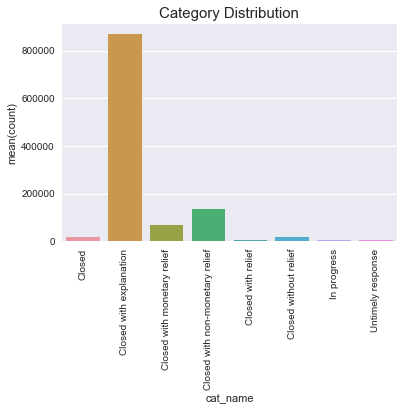

In [33]:
cat = combined["Company response to consumer"].value_counts().reset_index().rename(columns={'index': 'cat_name', 'Company response to consumer':'count'})
ax = sns.barplot(x="cat_name", y="count", data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Category Distribution', fontsize=15)
plt.show()

As you can see from the above plot bar that most of the consumer complaints falls into **'Closed with expalnation'** category, after that **'Closed with  non-monetary relief'** then **'Closed with monetary relief'**

## Preparing the corpus for Analysis  

a. Remove Puncuations

b. Remove Digits

c. Remove stop words

d. Lower case words

e. Lemmatization or Stemming

### Removing Punctuation

In [34]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
#Replacing punctuations

punctuation_symbols =[]

for p in punctuation:
    punctuation_symbols.append((p,''))

punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [36]:
import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

### Removing Digits

In [37]:
def remove_digit(s):
    s = ''.join([k for k in s if not k.isdigit()])
    return s

### Remove Stop Words

In [38]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

### Lowercase Words

In [39]:
def to_lower(x):
    return x.lower()

### Product Distribution

In [40]:
combined["Product"].nunique()

18

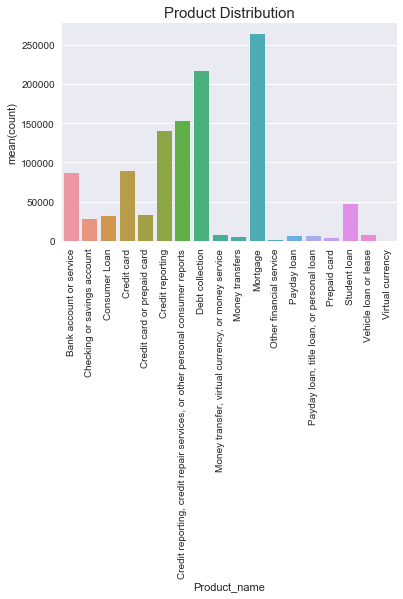

In [41]:
cat = combined["Product"].value_counts().reset_index().rename(columns={'index': 'Product_name', 'Product':'count'})
ax = sns.barplot(x="Product_name", y="count", data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Product Distribution', fontsize=15)
plt.show()

### Issue Distribution

From the below plot we got to know top 10 issues in th dataset.

,Issue,Complaint ID
0,"Loan modification,collection,foreclosure",112313
1,Incorrect information on credit report,102687
2,Incorrect information on your report,87535
3,"Loan servicing, payments, escrow account",77337
4,Cont'd attempts collect debt not owed,60698
5,"Account opening, closing, or management",37961
6,Problem with a credit reporting company's inve...,34475
7,Communication tactics,32092
8,Disclosure verification of debt,30802
9,Attempts to collect debt not owed,29662


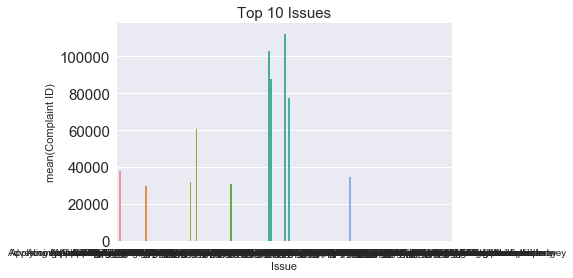

In [42]:
# Display Top 20 Issues By their Categories
top10_issue = combined.groupby('Issue', axis=0).count()

df_ID = pd.DataFrame(top10_issue.sort_values('Complaint ID', ascending = False)['Complaint ID'][0:10].reset_index())
ax = sns.barplot(df_ID.Issue, df_ID["Complaint ID"], data=df_ID)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
#ax.set_xticklabels(df_ID.Issue,rotation=60)
ax.set_title('Top 10 Issues', fontsize=15)
#plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df_ID
#plt.show()# Displayd frequency ratio of brand names

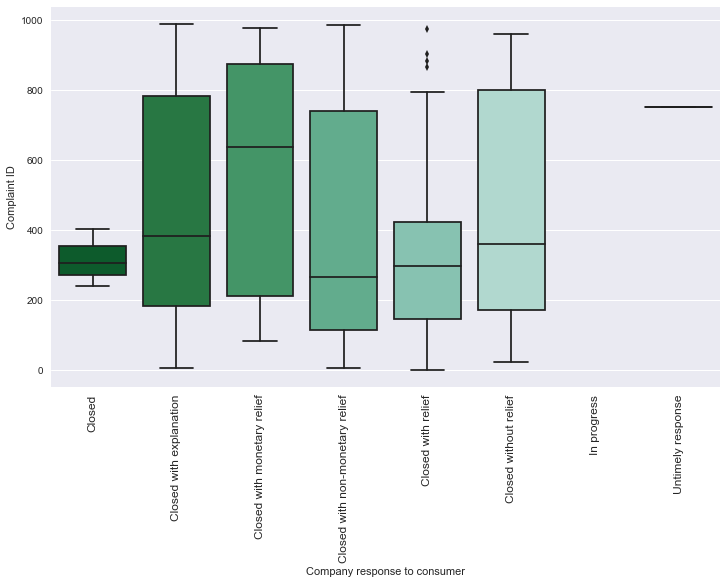

In [43]:
fig, axes = plt.subplots(figsize=(12, 7))
main = combined[combined["Complaint ID"]<1000]
# Use a color palette
ax = sns.boxplot( x=main["Company response to consumer"], y=main["Complaint ID"], palette="BuGn_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

sns.plt.show()

## Consumer Narrative Analysis

Hypothesis:

Does length play a role in final result?  
Does certain descriptions gives a same result?  
Lenghthier descriptions mean more effort in the process, more authentic, more valuable?  

In [44]:
# Remove Punctuation
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str)

descr = combined[["Consumer complaint narrative", "Company response to consumer"]]
descr['count'] = descr["Consumer complaint narrative"].apply(lambda x : len(str(x)))

descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_digit)
descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_punctuation)
descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_stop_words)

In [45]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(porter.stem)

In [46]:
descr.shape

(1124716, 3)

In [47]:
descr.tail(10)

,Consumer complaint narrative,Company response to consumer,count
925618,descript,Closed with explanation,17
82482,descript,Closed with non-monetary relief,17
500382,descript,Closed with non-monetary relief,17
590582,descript,Closed with explanation,17
855264,descript,Closed with non-monetary relief,17
147675,dear bcfp xxxx xxxx sister filed first reques...,Closed with explanation,858
379408,descript,Closed with explanation,17
971471,dear support representative discovered online ...,Closed with explanation,271
14993,descript,In progress,17
857061,descript,Closed with explanation,17


In [48]:
#df = descr.groupby("Company response to consumer")['count'].count().reset_index()
#.count().reset_index()
#sns.regplot(x=descr["Company response to consumer"], y=(descr['count']))
#plt.xlabel("word count")
#plt.show()

In [49]:
 combined.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1059561,12/10/2015,Credit reporting,Other,Credit monitoring or identity protection,Problem with fraud alerts,On XXXX XXXX of 2015 I requested my Equifax cr...,Other Description,"EQUIFAX, INC.",MA,021XX,Older American,Consent provided,Web,12/10/2015,Closed with explanation,Yes,No,1691642
378040,05/02/2014,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",Other,Other Description,Other Description,HIGHLANDS RESIDENTIAL MORTGAGE,VA,20147,NaN,NaN,Phone,05/06/2014,Closed with monetary relief,Yes,No,835706
583778,12/17/2014,Bank account or service,Checking account,Deposits and withdrawals,Other,Other Description,Other Description,JPMORGAN CHASE & CO.,LA,70119,NaN,NaN,Referral,12/17/2014,Closed with explanation,Yes,No,1160420
745282,05/09/2016,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,Not trying to still collect but debt was paid ...,Other Description,"The Law Firm of Ryan E. Calef and Associates, LLC",MN,553XX,Older American,Consent provided,Web,06/06/2016,Untimely response,No,No,1916990
440746,02/17/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Other,Other Description,Other Description,PNC Bank N.A.,DC,20003,NaN,NaN,Web,02/22/2012,Closed without relief,Yes,No,24703


In [50]:
# to_categorical - Converts Categorical Features 
def to_categorical(df):
    df['Product'] = df['Product'].astype('category')
    df['Sub-product'] = df['Sub-product'].astype('category')
    df['Issue'] = df['Issue'].astype('category')
    df['Sub-issue'] = df['Sub-issue'].astype('category')
    df['Company public response'] = df['Company public response'].astype('category')
    df['Consumer consent provided?'] = df['Consumer consent provided?'].astype('category')
    df['Company response to consumer'] = df['Company response to consumer'].astype('category')
    #df['Sub-product']  =  df['Sub-product'] .cat.add_categories(['Other'])
    #df['Sub-issue'] = df['Sub-issue'].cat.add_categories(['Other'])
    #df['Company public response'] = df['Company public response'].cat.add_categories(['None'])

## Applying Preprocessing Functions

In [51]:
# Applying the pre-processing functions
train_c =combined
#handle_missing_values(train)
to_categorical(combined)

In [52]:
# Remove Punctuation
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str)

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_digit)
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_punctuation)

combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].apply(remove_stop_words)
#train["Consumer complaint narrative"] = train["Consumer complaint narrative"].replace(['x','X'],'')
combined["Product"] = combined["Product"].apply(remove_digit)
combined["Product"] = combined["Product"].apply(remove_punctuation)
combined["Product"] = combined["Product"].apply(remove_stop_words)

combined["Issue"] = combined["Issue"].apply(remove_digit)
combined["Issue"] = combined["Issue"].apply(remove_punctuation)
combined["Issue"] = combined["Issue"].apply(remove_stop_words)


In [53]:
combined["Consumer complaint narrative"].head(10)

1059561    xxxx xxxx  requested equifax credit file froze...
378040                                           description
583778                                           description
745282     trying still collect debt paid full xxxx ryan ...
440746                                           description
708210                                           description
337624                                           description
783550                                           description
914782                                           description
742573                                           description
Name: Consumer complaint narrative, dtype: object

### Feature Extraction with text

**Feature Pre-Processing**: Sometimes you can't just fit a dataset into your model and expect good results. Each type of feature has their own way of preprocessing. Choice of preprocessing method also depends on the model we are trying to use.

Since we're working with Text Features, we're going to do a lot of vectorization:

**Tokenization**: split each text into words (bag of words model)  
**Stemming**: removing word inflections (getting the root word)  
**Vectorization**: reducing text into a vector with different types of frequencies for each word (Count Values or TF-IDF Values)

### Bag Of Words

When we vectorize these words, we're doing creating a feature for each word. Also known as, Bag of Words. We lose word ordering

**Solution:** To preserve some ordering, we can introduce n-grams into our vectorization of words (problem: too many features)

one way to reduce dimensions of n-grams is to remove stop words (a, the, is)
**stop words:** we can remove these words becaues they are just there for grammatical structure with little to no meaning
**n-gram**\   with smaller frequencies can highlight and capture important parts of a document/text. This preserves local ordering and can improve model performance.

In [54]:
combined.shape

(1124716, 18)

In [55]:
# Examine the normalize item description
combined =combined[combined['Consumer complaint narrative'] != 'description']


In [56]:
def dup_char(x):
    return (re.sub('[xx]','',x))

In [57]:
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str).apply(dup_char)

In [58]:
combined.shape

(323622, 18)

In [59]:
# Examine the normalize item description
combined['Consumer complaint narrative'][60:70]

374438     canceled  account  agreed new contract  years ...
473021     chase yet get back complaint   chg  hello fres...
257235     ok im escrowed  ditech sent  dollars  county t...
1024701    attempting avoid foreclosure sale completing s...
68721      loan transferred new servicer  uheaa  new serv...
990343     contacted   several times missing information ...
461712     default mortgage since able keep payments due ...
1099460    name    believe victim scam company dealt know...
944420     filed complaint almost two years ago mortgage ...
1099478    called quicken loans limited purpose obtaining...
Name: Consumer complaint narrative, dtype: object

In [60]:
#import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

text1 = combined['Consumer complaint narrative'].iloc[65]
tokens = word_tokenize(text1)


## TF - IDF

Main Goal - Measure how important a word or phrase is within a collection of documents. Its essentially **weigh down** terms that appear frequently and **scale up** unique terms.

** TF Term Frequency-** ( Number of times terms t appears in a document / Total number of terms in the document)  
** IDF Inverse Document Frequency-** log_e( Total number of documents / Number of documents with term t in it)  
** TF X IDF-** A measure of how important term in a document.  

* When you have a **high** term frequency in a document and it appears in many documents in the corpus = ** Low TFIDF**  
* When you have a **low** term frequency in a document and it appears in **not so many** documents in the corpus = ** High TFIDF**  

**CORPUS =  Collection of documents**  

** Important Parameters**  

1. ngram_range  
2. stop words  
3. lowercase  
4. max_df  :-  max threshold that will ignore a term that has a document frequency higher than that.    
5. min_df  :-  min threshold that will ignore a term that has a document frequency lower than that.  
6. max_features :- get the assigned amount of features with highest amount of term frequencies(scores).  



### Count Vectorizer

Generating new features of **Product Name** and **Issue**

In [61]:
# Apply Count Vectorizer to "Product", this converts it into a sparse matrix 

cv = CountVectorizer(min_df=10)
X_Product = cv.fit_transform(combined['Product'])
X_Product

print(str(X_Product.shape))

(323622, 29)


In [62]:
cv = CountVectorizer(min_df=10)
X_Issue = cv.fit_transform(combined['Issue'])
X_Issue

print(str(X_Issue.shape))

(323622, 210)


In [63]:
# Apply TFIDF to "Consumer complaint Narrative", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english',norm ='l1')
X_description = tv.fit_transform(combined['Consumer complaint narrative'])

print(str(X_description.shape))

(323622, 55000)


#### Observing TF-IDF weights

In [64]:

#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict( dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# Lowest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
credit,1.620392
account,1.849056
report,2.131541
received,2.239438
information,2.240613
time,2.324883
told,2.350991
company,2.351576
called,2.386675
payment,2.417743


In [65]:
# HIghest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
usd archive,12.994187
archive debit,12.994187
completed usd,12.588722
alleged banklender,12.588722
banklender servicer,12.588722
creditor simon,12.301040
details nv,12.077897
gasoline view,12.077897
warning llc,12.077897
nv supermarkets,12.077897


In [66]:
# Combine everything together
sparse_merge = hstack((X_description, X_Product, X_Issue)).tocsr()

In [67]:
sparse_merge.shape

(323622, 55239)

In [68]:
train_size

787301

In [70]:
X_train_sparse ,X_test  = train_test_split(sparse_merge, test_size=0.3)
print (X_train_sparse.shape, X_test .shape)

(226535, 55239) (97087, 55239)


In [76]:
%%time
from sklearn.decomposition import LatentDirichletAllocation


# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_topics=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(X_description)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = tv.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

C:\Users\Shringa\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic 0: knowledge debt | usc | failing report | violated usc | report complete | continuing collection | complete accurate | usc failing | desist usc | usc continuing
Topic 1: services reported | debt protection | contract received | adequate proof | ssn credit | contract business | business contract | updated correct | account ssn | provided adequate
Topic 2: scottrade | harris | opened date | ford | bsi | company responded | date filed | calling cell | didnt authorize | inquiries deleted
Topic 3: inquiry | inquiries | unauthorized | inquiry inquiry | authorize | hard | unauthorized inquiries | unauthorized inquiry | inquiries removed | inquiries credit
Topic 4: cra | cra violation | accounts | theft | belong | verify accounts | requests investigate | sure happened | late | verify
Topic 5: credit | account | report | debt | loan | credit report | information | payment | company | bank
Topic 6: hunter | warfield | hunter warfield | equifa hacked | equifa allowed | remove reports | inf